# Exploring Actor-Actor Interactions

A notebook for deriving actor-actor networks from the agreement-actor signatory data in order to explore:

1. Actor-actor relationships within various spaces — agreement, peace process, region, and agreement stage.
2. The use of hyergraphs to move beyond dyadic actor-actor relationships.
3. The use of topological data analysis (TDA) to explore the shape of actor-actor relationships.
4. Actor-actor relationships over time to look for fragmentation signals (e.g. breakdown of relationships between normative actors), and generation of new relationships between emerging actors (e.g. China, Russia, and GS actors) and normative actors.
5. Explore structural features of actor-actor networks: density, triangles, stars (with two or more arms), bridges (cuts) etc. For example, whether cutting a single edge generate two separate components. 
6. Network resilience. For example, how vulnerable is a network to a highly connected actor pulling out of a process.

The work here builds upon the methods described in this [report](https://peacerep.org/wp-content/uploads/2024/04/Methods-for-Agreement-Actor-Network-Analysis-PDF-2.pdf).



## Load code and data

Need to run `pip install scikit-tda`

- Load data into a biadjacency matrix with agreements in rows and actors in columns.
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one.
- Agreement and actor data are extracted or computed and mapped onto matrix rows and columns.
- All data are stored in `data_dict`.


In [5]:
__author__      = 'Roy Gardner'

%run ./network_functions.py

from matplotlib import cm
import matplotlib.colors as colors
from matplotlib_venn import venn2,venn3
from matplotlib_venn import venn2_circles,venn3_circles


from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components


# For TDA
import sktda
import ripser
import persim
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

def get_triangles(graph):
    # Graph statistic - the number of vertices in triangles
    return int(sum(nx.triangles(graph).values())/3)

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)


# The agreement-actor network

The complete agreement-actor network is a bipartite graph which we represent as a biadjacency matrix $\mathbf{B}$ where:

- Agreements are in rows and actors in columns.
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one.

A bipartite graph comprises two sets of vertices, in our case agreements and actors, where there are no connections between vertices of the same type, i.e., the only connections that exist are those between agreement and actors.

This means that actor-actor relationships are mediated by agreements. In other words, the shortest path between a pair of actors goes via an agreement. If a pair of actors are signatories to more than one agreement, then there will be multiple paths between the the actors. 

Agreement metadata values can be used to derive other matrices from $\mathbf{B}$. For example, a peace process agreement-actor biadjacency matrix $\mathbf{U}$ contains only those agreements and actors that belong to a selected peace process — see below. Such a matrix is a submatrix of $\mathbf{B}$. 

### Other types of matrix

Other useful biadjacency matrices might have peace processes, regions, or agreement stages in rows with actors in columns. The analysis described below could be applied to these matrices. For example, to determine the connectedness of actors in the peace process space.



## Actor-actor interactions in a peace process

This section examines interactions between actors that are mediated by the agreements of a peace process. The number of agreements a pair of actors have in common is regarded as a measure of the connectedness of the actors in the agreement space. 

As mentioned above, similar analyses are possible to examine the interactions of actors in other spaces, e.g., peace processes.

The first step is to select a peace process and then create the peace process biadjacency matrix $\mathbf{U}$ containing only those agreeements and actors that belong to the peace process.

An actor-actor adjacency matrix $\mathbf{V}$ is obtained by the transpose operation 

$$\mathbf{V}=\mathbf{U}^T\mathbf{U}$$  

on the peace process agreement-actor biadjacency matrix $\mathbf{U}$.

Cells in $\mathbf{V}$ contain the number of agreements a pair of actors have in common, i.e., the number of agreement-mediated paths between actors. Furthermore, we can recover the agreement IDs for a cell.

The actor-actor graph derived from the actor-actor adjacency matrix $\mathbf{V}$ provides:
- Edges weighted with the number of agreements a pair of actors have in common.
- Visualisation of the most connected actors.
- Clustering of actors at different weights.
- Possibility of further analysis using TDA.

The cell below generates the actor-actor matrix as described above for a selected peace process and produces two visualisations:

1. A network diagram of the actor-actor matrix. The colour of an edge indicates the weight of the connection between a pair of actors.
2. A histogram showing the distribution of connections over weights. 



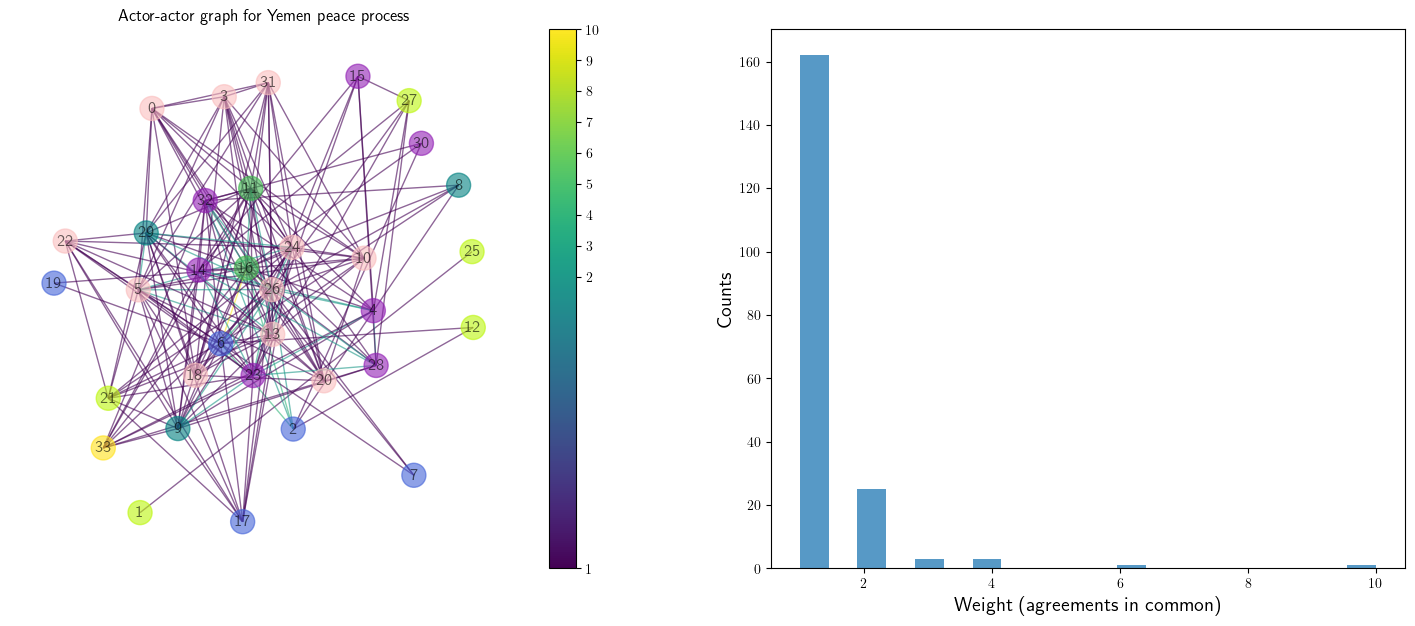

In [6]:
process_name = 'Bosnia peace process'
process_name = 'Yemen peace process'
#process_name = 'Chad: Doha process'
#process_name = 'DRC: Eastern DRC processes'
#process_name = 'Afghanistan: 2000s Post-intervention process'

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']

actor_upper = np.triu(np.matmul(pp_matrix.T,pp_matrix),k=1)
  
# Distribution of cell values == weights
weights = [v for v in actor_upper.flatten() if v > 0]

weights_dist = {}
for v in weights:
    if v == 0:
        continue
    if v in weights_dist:
        weights_dist[v] += 1
    else:
        weights_dist[v] = 1

weights_dist = sorted(weights_dist.items())

# plot graph
norm = colors.TwoSlopeNorm(
    vcenter=np.mean(weights),
    vmin=round(min(weights)),
    vmax=round(max(weights))
)
virdis_cmap = cm.get_cmap('viridis')


graph = nx.from_numpy_array(actor_upper, create_using=nx.Graph)
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
axs[0].set_title('Actor-actor graph for ' + process_name)
nx.draw(
    graph, ax=axs[0],
    pos=nx.spring_layout(graph, scale=80, k=2),
    #labels=nodes['name'].to_dict(),
    node_color=[data_dict['color_map'][v.split('_')[0]] for v in pp_data_dict['pp_actor_ids']],
    edge_color=virdis_cmap(norm(weights)),
    with_labels=True,
    alpha=0.6
)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=virdis_cmap), ax=axs[0])


axs[1].hist(weights,bins=20,alpha=0.75)
axs[1].set_xlabel("Weight (agreements in common)",fontsize='x-large')
axs[1].set_ylabel("Counts",fontsize='x-large')

plt.show()


### Clustering of actors

The weights distribution is use to obtain the set of discrete weight values for an actor-actor network with are then sorted in descending order. The code iterates the weight values and, at each weight value:

1. Creates an actor-actor submatrix containing only those actors connected by edges with a weight equal to or greater than the current weight value.
2. Displays the network diagram for the actor-actor submatrix.

As the process descends through the weight values the network increaes in complexity until it reaches the lowest weight at which point the entire network is displayed.

The descent reveals the most connected actors, the emergence of highly connected groups of actors, and in some case, the emergence of distinct cluster of actors.

The shape of clusters is revealing. For example, in a group of three actors that do not form a triangle the agreements sets are non-overlapping. In such a group one actor is central. The presence of a triangle, indicates a set of agreements common to all three actors.


Total number of actors: 34

Weight = 10 | Number of singletons = 32
Number of triangles: 0


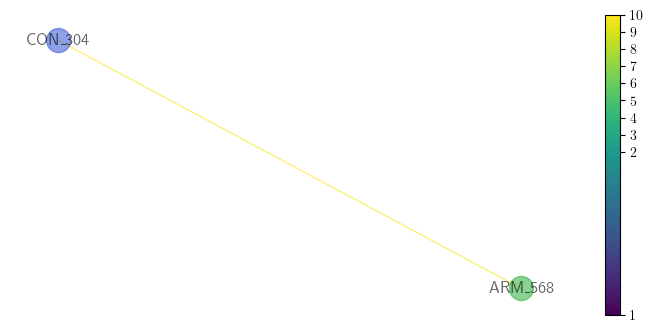

Weight = 6 | Number of singletons = 31
Number of triangles: 0


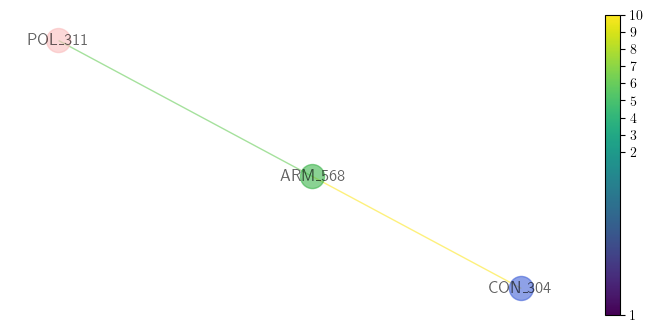

Weight = 4 | Number of singletons = 30
Number of triangles: 2


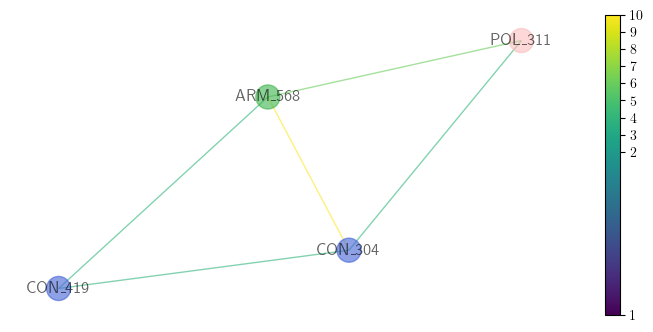

Weight = 3 | Number of singletons = 27
Number of triangles: 2


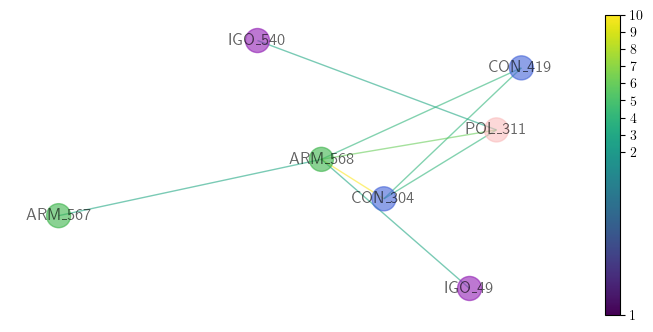

Weight = 2 | Number of singletons = 19
Number of triangles: 29


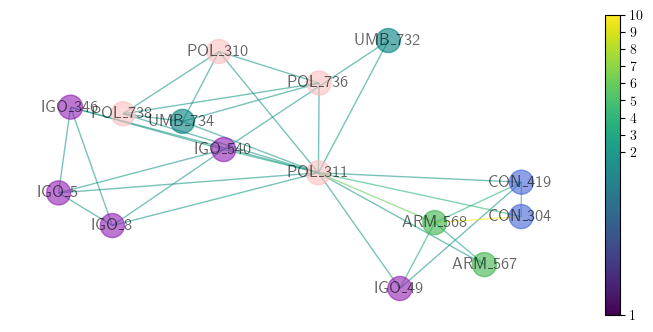

Weight = 1 | Number of singletons = 0
Number of triangles: 635


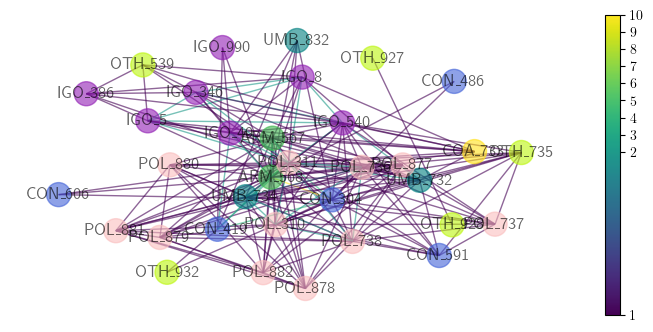

In [13]:

print('Total number of actors:',actor_upper.shape[0])
print()

# Edge weights of complete graph so we can get edge colours

weights = [v for v in actor_upper.flatten() if v > 0]
norm = colors.TwoSlopeNorm(
    vcenter=np.mean(weights),
    vmin=round(min(weights)),
    vmax=round(max(weights))
)
virdis_cmap = cm.get_cmap('viridis')

# We are going to descend through weights of the weights set to create graph at each weight
filter_weights = sorted(list(set(weights)),reverse=True)
for i,w in enumerate(filter_weights):
    # Build the subgraph for the weight value
    # Kill edges below filter_weight
    adj_matrix = actor_upper.copy()
    adj_matrix[adj_matrix < w] = 0
    # Get the actors with non-zero values in their rows and columns
    actor_indices = [i for row in adj_matrix for i,v in enumerate(row) if v > 0]
    actor_indices.extend([i for row in adj_matrix.T for i,v in enumerate(row) if v > 0])    
    actor_indices = sorted(list(set(actor_indices)))
    # Use the actor indices to get the actor submatrix
    adj_matrix = adj_matrix[np.ix_(actor_indices,actor_indices)]
    
    print('Weight =',w,'|','Number of singletons =',actor_upper.shape[0] - len(actor_indices))

    fig = plt.figure(figsize=(7,3))
    node_labels = {i:pp_data_dict['pp_actor_ids'][index] for i,index in enumerate(actor_indices)}
    node_colors = [data_dict['color_map'][v.split('_')[0]] for _,v in node_labels.items()]
    
    # Generate the graph and get the weights
    graph = nx.from_numpy_array(adj_matrix, create_using=nx.Graph) 
    
    print('Number of triangles:',get_triangles(graph))
    
    graph_weights = [e[2]['weight'] for e in graph.edges.data()]
    
    nx.draw(
        graph,
        pos=nx.spring_layout(graph, scale=80, k=2),
        labels=node_labels,
        node_color=node_colors,
        edge_color=virdis_cmap(norm(graph_weights)),
        with_labels=True,
        alpha=0.6
    )
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=virdis_cmap))
    plt.show()


## Time series analysis

Explore how actor-actor networks change over time.

- FIRST PASS.
- Using aggregated actor-actor weights for colorbar. Need to base on precomputed weights across years.
- Combine weight analysis with time series analysis.

### TODO

1. Add actor engagements plot
2. Add actor query time series (see network doc)



In [ ]:
# Start with year as minimum interval
# Not sorting agreements by date with year

# Organise agreements by year
year_dict = {}
for agreement_id in pp_data_dict['pp_agreement_ids']:
    date = get_agreement_date(agreement_id,data_dict)
    year = int(date.split('-')[0])
    if year in year_dict:
        year_dict[year].append(agreement_id)
    else:
        year_dict[year]= [agreement_id]
        
years = sorted(year_dict.items(),key=lambda kv:kv[0])
#print(years)

for year_data in years:
    # Get the peace process biadjacency matrix for year
    agreement_ids = year_data[1]
    agreement_indices = [i for i,agreement_id in enumerate(pp_data_dict['pp_agreement_ids']) if\
                        agreement_id in agreement_ids]
    sub_matrix = pp_data_dict['pp_matrix'][np.ix_\
                                           (agreement_indices,range(0,len(pp_data_dict['pp_actor_ids'])))]
    actor_upper = np.triu(np.matmul(sub_matrix.T,sub_matrix),k=1)
    
    adj_matrix = actor_upper.copy()
    adj_matrix[adj_matrix < 1] = 0
    # Get the actors with non-zero values in their rows and columns
    actor_indices = [i for row in adj_matrix for i,v in enumerate(row) if v > 0]
    actor_indices.extend([i for row in adj_matrix.T for i,v in enumerate(row) if v > 0])    
    actor_indices = sorted(list(set(actor_indices)))
    # Use the actor indices to get the actor submatrix
    adj_matrix = adj_matrix[np.ix_(actor_indices,actor_indices)]
    
    node_labels = {i:pp_data_dict['pp_actor_ids'][index] for i,index in enumerate(actor_indices)}
    node_colors = [data_dict['color_map'][v.split('_')[0]] for _,v in node_labels.items()]

    
    graph = nx.from_numpy_array(adj_matrix, create_using=nx.Graph)
    
    graph_weights = [e[2]['weight'] for e in graph.edges.data()]

    pos = nx.spring_layout(graph, scale=80, k=2)
    fig = plt.figure(figsize=(7, 3))
    plt.title('Actor-actor graph for ' + str(year_data[0]) +\
             '. Number of agreements = ' + str(len(agreement_ids)))
    nx.draw(
        graph,
        pos=pos,
        labels=node_labels,
        node_color=node_colors,
        edge_color=virdis_cmap(norm(graph_weights)),
        with_labels=True,
        alpha=0.6
    )
    
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=virdis_cmap))


    #axs[1].hist(weights,bins=20,alpha=0.75)
    #axs[1].set_xlabel("Weight (agreements in common)",fontsize='x-large')
    #axs[1].set_ylabel("Counts",fontsize='x-large')

    plt.show()


# Beyond dyadic relationships

Traditional network analysis is based on dyadic relationships, i.e. connnections between pairs of vertices (nodes) in a network. An edge is an interaction set $I$ containing two vertices, i.e., $|I|=2$.


This is true for the foregoing, and some caution is required when interpreting actor-actor relationships. For example, if we find that actor $s_1$ has a set of 12 agreements in common with actor $s_2$, and that actor $s_1$ also has a set of 12 agreements in common with actor $s_3$, we can't assume that the two sets of 12 agreements are the same.


## Exploring dyadic actor-actor relationships

The actor relationships in the network below are taken from the Yemen peace process and show the interaction of three actors. The central actor `ARM_568` has 10 agreements in common with `CON_304`, and six agreements in common with `POL_311`. However, the set of six agreements may not be a subset of the set of 10 agreements.


![title](assets/star.png)


In the network below, actor interactions with four or more agreements are shown. An additional actor, `CON_419`, appears and the complexity of the network increases to include triangles. Specifically, `ARM_568`, `CON_304`, and `POL_311` now form a triangle in which `CON_304` and `POL_311` have four agreements in common.

![title](assets/tri.png)


The cells below explore the interactions between `ARM_568`, `CON_304`, and `POL_311` to determine exactly what agreements, if any, the three actors have in common.


### Step 1

We find the identities of the agreements that connect pairs of actors to provide two sets of agreements:

- The set of agreements common to the pair `(ARM_568,CON_304)`
- The set of agreements common to the pair `(ARM_568,POL_311)`

By plotting a Venn diagram we can visualise the intersection of these two sets and determine that the pairs `(ARM_568,CON_304)` and `(ARM_568,POL_311)` have three agreements in common. We then obtain the identities of the three agreements in the intersection set.

With the constraint that agreements are unique, i.e., the set of all agreements contains no duplicates, we can prove that the set of agreements common to the pair `(CON_304,POL_311)` contains the intersection set of the pairs `(ARM_568,CON_304)` and `(ARM_568,POL_311)`.

Let $\{A,B,C\}$ be the sets of agreements belonging to three actors $\{a,b,c\}$ where $a$ is connected to $b$ and $c$, but where $b$ not connected to $c$, and $(A \cap B) \cap (A \cap C) \neq \emptyset$.

If $x \in (A \cap B) \cap (A \cap C)$ then:

$$
x \in (A \cap B)\\
x \in B\\
x \in (A \cap C)\\
x \in C\\
x \in B \cap C\\
\therefore ((A \cap B) \cap (A \cap C)) \in (B \cap C)
$$

Everything in the intersection of the intersections $A \cap B$ and $A \cap C$ is in the intersection $B \cap C$.

In the next step, we confirm this.


{'ARM_568': array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1]), 'CON_304': array([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0]), 'POL_311': array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1])}
Agreements that ARM_568 and CON_304 have in common: {'AGT_1824', 'AGT_1434', 'AGT_2122', 'AGT_2121', 'AGT_1825', 'AGT_1734', 'AGT_2008', 'AGT_2120', 'AGT_1433', 'AGT_1586'}

Agreements that ARM_568 and POL_311 have in common: {'AGT_1400', 'AGT_1884', 'AGT_1825', 'AGT_1734', 'AGT_1586', 'AGT_2014'}



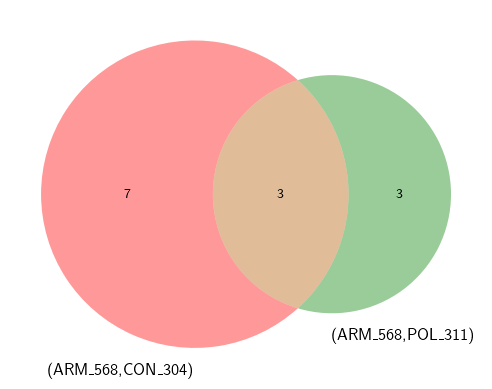

Agreements that pairs (ARM_568,CON_304) and (ARM_568,POL_311) have in common: {'AGT_1825', 'AGT_1734', 'AGT_1586'}



In [86]:
process_name = 'Yemen peace process'

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']

actor_upper = np.triu(np.matmul(pp_matrix.T,pp_matrix),k=1)

# Get the agreement vectors for the actors of interest
actor_ids = ['ARM_568','CON_304','POL_311']
vectors_dict = {}
for actor_id in actor_ids:
    actor_index = pp_data_dict['pp_actor_ids'].index(actor_id)
    vectors_dict[actor_id] = pp_matrix[:,actor_index]

# Find the 10 agreements that ARM_568 and CON_304 have in common
r1 = np.bitwise_and(vectors_dict['ARM_568'],vectors_dict['CON_304'])
r1_agreements = set([pp_data_dict['pp_agreement_ids'][i] for i,v in enumerate(r1) if v==1])
print('Agreements that ARM_568 and CON_304 have in common:',r1_agreements)
print()

# Find the six agreements that ARM_568 and POL_311 have in common
r2 = np.bitwise_and(vectors_dict['ARM_568'],vectors_dict['POL_311'])
r2_agreements = set([pp_data_dict['pp_agreement_ids'][i] for i,v in enumerate(r2) if v==1])
print('Agreements that ARM_568 and POL_311 have in common:',r2_agreements)
print()

venn2([r1_agreements,r2_agreements],['(ARM_568,CON_304)','(ARM_568,POL_311)'])
plt.show()

# Get the intersection of the r1 and r2 sets
inter = r1_agreements.intersection(r2_agreements)
print('Agreements that pairs (ARM_568,CON_304) and (ARM_568,POL_311) have in common:',inter)
print()



### Step 2

We find the identities of the agreements that connect the pair of actors `(CON_304,POL_311)`. We then plot a Venn diagram to show the interaction of all three actor pairs: `(ARM_568,CON_304)`, `(ARM_568,POL_311)`, and `(CON_304,POL_311)`.

The analysis confirms that our three pairs of actors have three agreements in common.


Agreements that CON_304 and POL_311 have in common: {'AGT_1401', 'AGT_1586', 'AGT_1734', 'AGT_1825'}



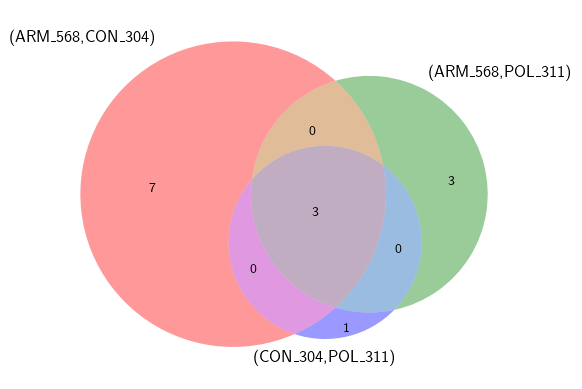

Agreements that pairs (ARM_568,CON_304),(ARM_568,POL_311),(CON_304,POL_311) and have in common: {'AGT_1586', 'AGT_1734', 'AGT_1825'}



In [39]:

r3 = np.bitwise_and(vectors_dict['CON_304'],vectors_dict['POL_311'])
r3_agreements = set([pp_data_dict['pp_agreement_ids'][i] for i,v in enumerate(r3) if v==1])
print('Agreements that CON_304 and POL_311 have in common:',r3_agreements)
print()

venn3([r1_agreements,r2_agreements,r3_agreements],\
      ['(ARM_568,CON_304)','(ARM_568,POL_311)','(CON_304,POL_311)'])
plt.show()

# Get the intersection of the r1, r2, and r3 sets
inter = r1_agreements.intersection(r2_agreements).intersection(r3_agreements)
print('Agreements that pairs (ARM_568,CON_304),(ARM_568,POL_311),(CON_304,POL_311) and have in common:',\
      inter)
print()


## Finding isometric clusters of actors

In [32]:
process_name = 'Yemen peace process'

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']

actor_upper = np.triu(np.matmul(pp_matrix.T,pp_matrix),k=1)
graph = nx.from_numpy_array(actor_upper, create_using=nx.Graph)

#triangles = nx.triangles(graph)
#print(triangles)
#print(list(nx.triangles(graph, [0, 1]).values()))

cliques = nx.enumerate_all_cliques(graph)
tri_cliques = [x for x in cliques if len(x)==3]    
#print(len(tri_cliques))
#print(tri_cliques)



clique_ranks = {}
for i,c in enumerate(tri_cliques):
    labels = [pp_data_dict['pp_actor_ids'][actor_index] for actor_index in c]
    #if labels != ['CON_304', 'ARM_568', 'POL_311'] and labels != ['CON_419', 'CON_304', 'POL_311']:
    #    continue
    #print(c)
    agreement_vectors = [pp_matrix[:,actor_index] for actor_index in c]
    #print(agreement_vectors)
    
    bitset = np.bitwise_and(agreement_vectors[0],agreement_vectors[1])
    bitset = np.bitwise_and(bitset,agreement_vectors[2])
    rank = len([v for v in bitset if v==1])
    if rank in clique_ranks:
        clique_ranks[rank].append(labels)
    else:
        clique_ranks[rank] = [labels]
    #if i == 0:
    #    break
print(clique_ranks.keys())
print(clique_ranks[3])


dict_keys([1, 3, 2, 0])
[['CON_419', 'CON_304', 'ARM_568'], ['CON_304', 'ARM_568', 'POL_311']]


### Get clique submatrix and visualise as network

 - If triangular cliques join then can prove all edges contain the same agreements.
 

['CON_304', 'ARM_568', 'CON_419', 'POL_311']


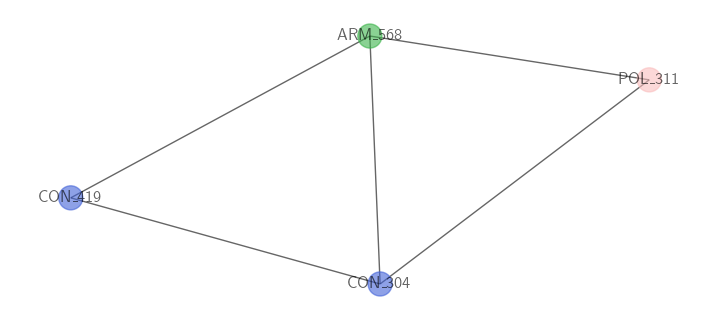

['CON_304', 'ARM_568', 'POL_311']
AGT_1586
AGT_1824
AGT_1825
['CON_419', 'CON_304', 'ARM_568']
AGT_1586
AGT_1824
AGT_1825


In [40]:
rank = 3

clique_ids = []
for clique in clique_ranks[rank]:
    clique_ids.extend(clique)

clique_ids = list(set(clique_ids))
print(clique_ids)

adj_matrix = actor_upper.copy()

actor_indices = [pp_data_dict['pp_actor_ids'].index(clique_id) for clique_id in clique_ids]
adj_matrix = adj_matrix[np.ix_(actor_indices,actor_indices)]
# Threshold the matrix
adj_matrix[adj_matrix < rank] = 0
fig = plt.figure(figsize=(7,3))
node_labels = {i:pp_data_dict['pp_actor_ids'][index] for i,index in enumerate(actor_indices)}
node_colors = [data_dict['color_map'][v.split('_')[0]] for _,v in node_labels.items()]

# Generate the graph and get the weights
graph = nx.from_numpy_array(adj_matrix, create_using=nx.Graph) 

nx.draw(
    graph,
    pos=nx.spring_layout(graph, scale=80, k=2),
    labels=node_labels,
    node_color=node_colors,
    with_labels=True,
    alpha=0.6
)
plt.show()

    
labels_list = [['CON_304', 'ARM_568', 'POL_311'],['CON_419', 'CON_304', 'ARM_568']]

for labels in labels_list:
    print(labels)
    actor_indices = [pp_data_dict['pp_actor_ids'].index(clique_id) for clique_id in clique_ids]
    agreement_vectors = [pp_matrix[:,actor_index] for actor_index in actor_indices]

    bitset = np.bitwise_and(agreement_vectors[0],agreement_vectors[1])
    bitset = np.bitwise_and(bitset,agreement_vectors[2])
    for i,v in enumerate(bitset):
        if v == 1:
            print(pp_data_dict['pp_agreement_ids'][i])



In [41]:
for actor_id in pp_data_dict['pp_actor_ids']:
    print(actor_id,get_actor_name(actor_id,data_dict))
    

POL_879 Al-Rashad Union
OTH_927 National Committee Prisoners Affairs & Missing Persons
CON_419 Saudi Arabia
POL_882 Justice and Construction Party
IGO_8 UN Security Council
POL_738 Al - Haqq
CON_304 Yemen
CON_606 Oman
UMB_832 Arab Coalition
UMB_732 Joint Meeting Parties
POL_880 Popular Unificationist Nasserite Organization
ARM_567 Southern Movement
OTH_932 Southern Transitional Council
POL_310 Yemeni Socialist Party
IGO_5 European Union
IGO_386 UN Secretary General
ARM_568 Ansar Allah
CON_591 United Arab Emirates
POL_878 Union of Popular Forces
CON_486 Qatar
POL_877 Arab Baath Socialist Party
OTH_735 Preparatory Committee for National Dialogue
POL_737 Solidarity Council and the Freedom Bloc
IGO_540 Gulf Cooperation Council
POL_736 Yemeni Congregation for Reform
OTH_928 Foundation and Representative Prisoners Affairs & Missing Persons of the Arab Coalition 
POL_311 General People's Congress
OTH_539 National Council
IGO_346 League of Arab States
UMB_734 National Democratic Alliance
IGO_9

In [132]:
process_name = 'Yemen peace process'

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']

actor_upper = np.triu(np.matmul(pp_matrix.T,pp_matrix),k=1)
graph = nx.from_numpy_array(actor_upper, create_using=nx.Graph)

cliques = nx.find_cliques(graph)
cliques = [x for x in cliques]    
print(len(cliques))
print(cliques)



for i,c in enumerate(cliques):
    labels = [pp_data_dict['pp_actor_ids'][actor_index] for actor_index in c]
    print(labels)


13
[[0, 10, 6, 8, 26, 12, 30], [0, 16, 5, 1, 7, 14, 27, 9, 26], [0, 16, 5, 1, 7, 14, 27, 2, 3, 17, 18, 28, 15], [0, 16, 5, 6, 8, 9, 26, 12, 13, 22], [0, 16, 11, 24, 25, 22], [0, 16, 11, 9, 26, 1, 27, 14, 7], [0, 16, 11, 9, 26, 22], [0, 16, 11, 29], [0, 21, 1, 7, 9, 11, 14, 26, 27, 31, 23], [32, 16, 25, 22], [33, 16, 11], [4, 25, 11], [19, 20]]
['POL_311', 'OTH_539', 'IGO_5', 'IGO_346', 'IGO_540', 'IGO_8', 'IGO_386']
['POL_311', 'ARM_568', 'ARM_567', 'UMB_734', 'POL_736', 'POL_310', 'POL_738', 'UMB_732', 'IGO_540']
['POL_311', 'ARM_568', 'ARM_567', 'UMB_734', 'POL_736', 'POL_310', 'POL_738', 'POL_879', 'POL_877', 'POL_878', 'POL_880', 'POL_881', 'POL_882']
['POL_311', 'ARM_568', 'ARM_567', 'IGO_5', 'IGO_346', 'UMB_732', 'IGO_540', 'IGO_8', 'COA_733', 'IGO_49']
['POL_311', 'ARM_568', 'CON_304', 'UMB_832', 'CON_419', 'IGO_49']
['POL_311', 'ARM_568', 'CON_304', 'UMB_732', 'IGO_540', 'UMB_734', 'POL_738', 'POL_310', 'POL_736']
['POL_311', 'ARM_568', 'CON_304', 'UMB_732', 'IGO_540', 'IGO_49'

### Summary

It's not that dyadic relationships are not useful. For a given actor, we can easily determine the degree to which they interact with other actors in terms of agreements in common. Furthermore, the diagonal of an actor-actor matrix tells us the number of agreements to which an actor is a signatory.

We can find pairs of actors with the highest number of agreements in common which is a measure of their mutual interaction in a peace process. Furthermore, we can measure these pairwise interactions over time. 

We are not even restricted to agreements, and can, for example, measure actor-actor interactions in the peace process, and stage of agreement spaces.


So what's missing? We get a sense of what's missing from the analysis above. By examining three actors we were able to use the actor-actor and agreement-actor matrices to determine the set of agreements the actors have in common. At a glance, we seemed able to break out of a strictly dyadic model to determine the interactions of three actors.  

However, this breakout came at a cost of set based operations on dyadic relationships, the number of combinations of which would increase rapidly as the number of actors in an analysis increased. Given our actor-actor relationships are undirected, i.e., the order of a pair is irrelevant, and we don't want repetition the number of pairwise combinations of $n$ actors is given by:


$$\frac{n!}{(n-2)!2!}$$

This quickly becomes unwieldy. If we want to model interactions between sets of actors where $|I| > 2$, then we need another analytical tool.

#### Actor-actor network as multigraph

As a stepping stone towards a better way of representing interactions between actors, we can consider the actor-actor graph as a multigraph. This involves separating the single edge between a pair of actors into multiple edges, one for each agreement a pair of actors have in common. We could even label each of these multiple edges with an agreement ID.

In a network visualisation, we would be able to see that the same agreement edge connected more than one pair of actors. However, this would provide no further advantage and would be no more than a network representation of the computations already discussed above. 

However, the multigraph abstraction does makes explicit the fact that a single agreement edge can connect multiple actors. This leads to *hypergraphs*, and the treatment of an agreement as a *hyperedge* that connects multiple actors.


## Hypergraphs: Agreements as edges

An edge in a hypergraph defines an interaction set $I$ containing one or more vertices. In our application $|I| > 2$.

By way of introduction, we create a toy peace process network comprising three actors ${s_1,s_2,s_3}$ and three agreements ${a_1,a_2,a_3}$. Our pairwise actor interactions are:

- ${s_1,s_2}$ are connected by ${a_1,a_3}$
- ${s_1,s_3}$ are connected by ${a_2,a_3}$
- ${s_2,s_3}$ are connected by ${a_3}$

The hypergraph of this network is shown below. The agreements are represented by ellipses that enclose actors.

![title](assets/hyper2.png)



We can now return to a peace process biadjacency matrix $\mathbf{U}$, take the transpose $\mathbf{I} = \mathbf{U^T}$, and treat $\mathbf{I}$ as an *incidence* matrix with vertices (actors) in rows and edges (agreements) in columns. Unlike a dyadic network's indicence matrix where each edge connects only two vertices, the edges in the hypergraph incidence matrix connect multiple actors.


### \*Stashed\*

Actors in agreement space:

- The number of dimensions of the agreement space is the number of agreements.
- Hypercube model. 
    - Agreements are binary-valued dimensions.
    - Actors are on vertices of the hypercube.


### Transpose of agreement-actor matrix as incidence matrix

- Actors in rows
- Edges (agreements) in columns


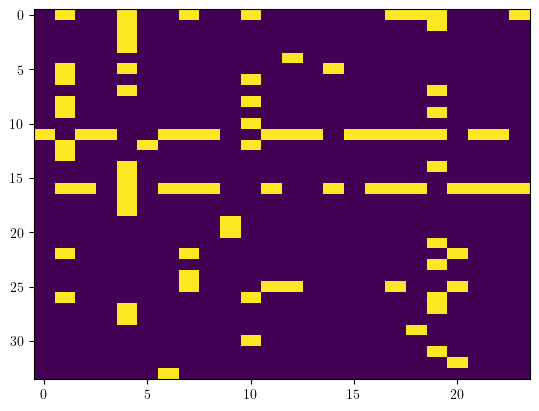

In [136]:
process_name = 'Yemen peace process'

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['pp_matrix']

plt.imshow(pp_matrix.T,aspect='auto')
plt.show()


### Toys

How to find the isometric actor clusters.


In [159]:
# Four actors in rows, three edges in columns

incidence = []

incidence.append([1,1,0])
incidence.append([1,1,1])
incidence.append([0,0,1])
incidence.append([1,1,0])

incidence = np.array(incidence)
print(incidence)
print()

a = np.matmul(incidence,incidence.T)
print(a)
print()


[[1 1 0]
 [1 1 1]
 [0 0 1]
 [1 1 0]]

[[2 2 0 2]
 [2 3 1 2]
 [0 1 1 0]
 [2 2 0 2]]



[[1 0 1]
 [1 0 1]
 [1 1 0]
 [1 1 1]]

[[0 2 3]
 [0 0 1]
 [0 0 0]]

[1 1 1 1]
[0 0 1 1]
[1 1 0 1]

[0 0 1 1]
[1 1 0 1]
[0 0 0 1]

[0 0 0 1]
[0 0 0 1]
[0 0 0 1]


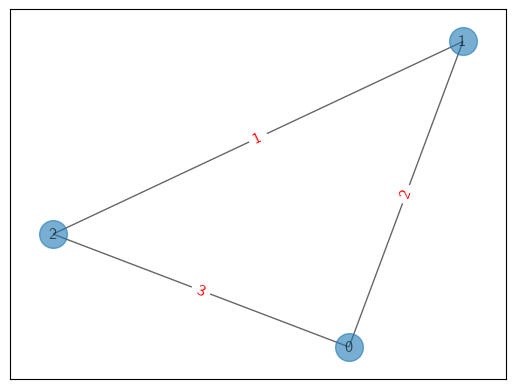

In [221]:
# Make an agreement-actor matrix
aa = []
aa.append([1,0,1])
aa.append([1,0,1])
aa.append([1,1,0])
aa.append([1,1,1])
aa = np.array(aa)
print(aa)
print()

# Make an actor-actor matrix
a = np.triu(np.matmul(aa.T,aa),k=1)
print(a)
print()

graph = nx.from_numpy_array(a, create_using=nx.Graph)
pos = nx.spring_layout(graph) 
nx.draw_networkx(graph,pos,node_size=400,font_size=12,alpha=0.6)
rc = np.nonzero(a) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
edge_labels = {t:a[t[0]][t[1]] for t in z}
nx.draw_networkx_edge_labels(graph, pos,edge_labels,font_color='red',font_size=12)

print(aa[:,0])
print(aa[:,1])
print(aa[:,2])
print()

b1 = np.bitwise_and(aa[:,0],aa[:,1])
b2 = np.bitwise_and(aa[:,0],aa[:,2])
b3 = np.bitwise_and(aa[:,1],aa[:,2])
print(b1)
print(b2)
print(b3)
print()
print(np.bitwise_and(b1,b2))
print(np.bitwise_and(b1,b3))
print(np.bitwise_and(b2,b3))


# Topological data analysis (TDA)

is symmetric = True
3


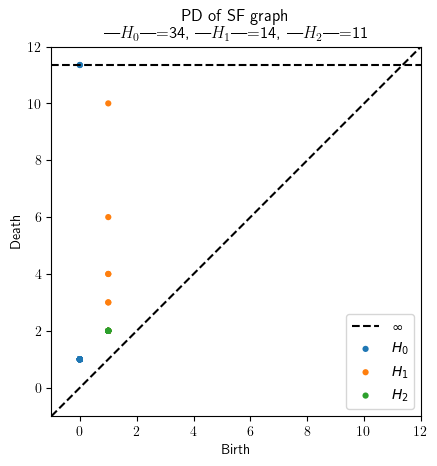

In [9]:
# Convert the actor-actor graph to a distance matrix

pp_matrix = pp_data_dict['pp_matrix']
# Convert matrix values to float
actor_matrix = np.matmul(pp_matrix.T,pp_matrix).copy().astype(float)

# 1. Compute the inverse of the cell values
np.divide(1, actor_matrix, where=actor_matrix>0)

# 2. Set values with a zero value to infinity
actor_matrix[actor_matrix == 0] = np.inf

# 3. Set the diagonal to all zeros, i.e. there is no distance between an actor and itself
np.fill_diagonal(actor_matrix, [0]*len(actor_matrix))

# 4. Round the matrix cell values
actor_matrix = np.round(actor_matrix, 4)

print(f"is symmetric = {np.allclose(np.asarray(actor_matrix.T), np.asarray(actor_matrix))}")

dgms = ripser.ripser(actor_matrix, distance_matrix=True, maxdim=2)['dgms']
print(len(dgms))
persim.plot_diagrams(
    dgms, show=True,
    title=f"PD of SF graph\n{diagram_sizes(dgms)}"
)
